# Rainy days on the stock market

Dataproject by Josefine Pedersen, Viktor Texel and Pernille Svendsen

> **Table of contents** 
> - Import and set magics
> - Introduction
> - Read and clean data from DMI and Yahoo Finance
> - Exploration of datasets
> - Merging of datasets
> - Analysis
> - Conclusion

*Imports and set magics:*

In [30]:
# Import of tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import requests # library for making HTTP requests
import datetime as dt # library for handling date and time objects
from PIL import Image

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

# Installation and import of data-specific tools and packages

# We install a package to inspect data from DMI (Danish Meteorological Institute):
#%pip install dmi-open-data

# We install nescesarry packages for Yahoo Finance

#%pip install yfinance
#%pip install yahoofinancials

import yfinance as yf

from yahoofinancials import YahooFinancials

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

In this dataproject we wish to explore if there could be a correlation between weather and developments on the stock market. Through API's we import datasets from DMI and Yahoo Finance to examine whether or not there is a correlation between price fluctuations in the danish OMX C25-index and the amount of precipitation that falls in Denmark. 

To do so, we carefully select comparable data from our datasets and analyze it using different python-tools. We find that there is litte-to-no correlation between precipitation and fluctuations in the share price of OMX C25 in Denmark.  

# Read and clean data from DMI and Yahoo Finance

In this section we import our data through API's and load it. To do so, the packages *dmi-open data*, *yfinance* and *yfinancials* needs to be installed. These are included at the top in our *import and set magics* section and can be installed by removing the '#' and then running the code. 

**We import data from DMI**:

In [31]:
# We use an API-key given to us from DMI's database to locate data
api_key = 'bd463c7d-f6f8-431d-a5a7-c466766a8363'
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

# Issues a HTTP GET request
r = requests.get(DMI_URL, params={'api-key': api_key}) 
print(r)

<Response [200]>


The response [200] means that we have succesfully requested the data. **KAN VI IKKE ÆNDRER DET, SÅ DEN SIGER NOGET MERE SMART - SÅ MAN FX IKKE BEHØVER HAVE DET HER MARKDOWN-FELT?**

We examine the data requested and print the available parameters.

In [36]:
# Extract JSON data
json = r.json()

# Print the keys of the JSON dictionary
print(json.keys())

# Convert JSON object to a Pandas DataFrame
df = pd.json_normalize(json['features'])  

df['time'] = pd.to_datetime(df['properties.observed'])

# Generate a list of unique parameter ids
parameter_ids = df['properties.parameterId'].unique() 

# Print all unique parameter ids
print(parameter_ids) 

dict_keys(['type', 'features', 'timeStamp', 'numberReturned', 'links'])
['temp_dew' 'humidity' 'cloud_cover' 'temp_max_past12h' 'pressure_at_sea'
 'wind_speed' 'temp_soil_max_past1h' 'weather' 'wind_dir' 'temp_dry'
 'precip_dur_past10min' 'temp_grass' 'leav_hum_dur_past10min'
 'temp_min_past1h' 'precip_past1min' 'precip_past1h' 'pressure'
 'radia_glob' 'wind_speed_past1h' 'humidity_past1h' 'sun_last10min_glob'
 'precip_past10min' 'visib_mean_last10min' 'leav_hum_dur_past1h'
 'visibility' 'temp_soil' 'temp_soil_min_past1h' 'wind_min'
 'temp_grass_min_past1h' 'wind_min_past1h' 'cloud_height'
 'temp_min_past12h' 'wind_max_per10min_past1h' 'temp_max_past1h'
 'temp_soil_mean_past1h' 'wind_max' 'wind_dir_past1h' 'precip_dur_past1h'
 'temp_grass_mean_past1h' 'wind_gust_always_past1h' 'sun_last1h_glob'
 'temp_mean_past1h' 'radia_glob_past1h' 'temp_grass_max_past1h'
 'snow_depth_man']


From the parameters above, we select the parameter *precip_past1h* which returns the amount of precipitation within a given period in kg/m2 in hourly format.

As we have now picked the necessary parameter for our analysis, we have to specify what timeperiod we wanna look at, which DMI-weather stations is relevant to include, and how to structure our DMI-dataset.

We wanna look at the most recent full year, 2022. Therefore we specify our timeperiod to start at the first hour of the first day of 2022, and end at the first hour of the first day of 2023. 

DMI has a lot of weatherstations scattered across Denmark, The Faroe Islands and Greenland. These weather stations have different capabilities, and some measure the same as others - meaning there is a risk of having measurements for the geographical location twice. We only wanna look at *Pluvio* stations in Denmark, as these measure precipitation. Therefore we sort our data to only include *Pluvio* station IDs. 

The *Pluvio* stations are located as depicted below:

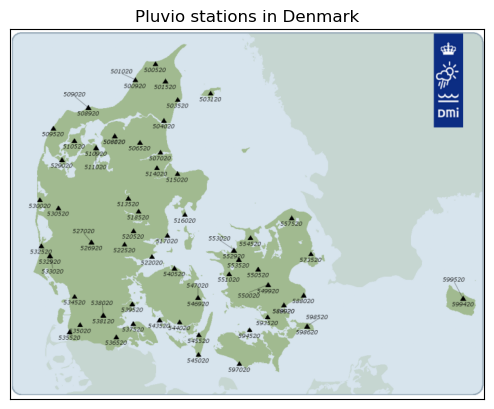

In [40]:
# Open the image file
img = Image.open("C:/Users/vikto/Documents/A Økonomi/8. Semester/IntroProg/DMI pic.png")

# Convert the image to a NumPy array
img_array = plt.imread("C:/Users/vikto/Documents/A Økonomi/8. Semester/IntroProg/DMI pic.png")

# Show the image in a plot
plt.imshow(img_array)
plt.title('Pluvio stations in Denmark')
plt.xticks([])
plt.yticks([])
plt.show()

**I KODEN NEDENUNDER ER DER 2 LIGNINGER DER ER '#' I IF-STATEMENTET - KAN DET SLETTES?**

In [37]:
# Specify the desired start and end time
start_time = pd.Timestamp(2022, 1, 1)
end_time = pd.Timestamp(2023, 1, 1)

# Specify our selection of station IDs
all_stationsDK = [
    '05005', '05009', '05015', '05031', '05035', '05042', '05065', 
    '05070', '05075', '05081', '05085', '05089', '05095', '05105', 
    '05109', '05135', '05140', '05150', '05160', '05165', '05169', 
    '05185', '05199', '05202', '05205', '05220', '05225', '05269', 
    '05272', '05276', '05277', '05290', '05296', '05300', '05305', 
    '05320', '05329', '05343', '05345', '05350', '05355', '05365', 
    '05375', '05381', '05395', '05400', '05406', '05408', '05435', 
    '05440', '05450', '05455', '05469', '05499', '05505', '05510', 
    '05529', '05537', '05545', '05575', '05735', '05880', '05889', 
    '05935', '05945', '05970', '05986', '05994'
]

# Specify one or more parameter IDs or all_parameters
parameterId = ['precip_past1h']

# Derive datetime specifier string
datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()

dfs = []
for station in all_stationsDK:
    for parameter in parameterId:
        # Specify query parameters
        params = {
            'api-key' : api_key,
            'datetime' : datetime_str,
            'stationId' : station,
            'parameterId' : parameter,
            'limit' : '300000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL, params=params)

        # Extract JSON object
        json = r.json()
        
        # Convert JSON object to a MultiIndex DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        if dfi.empty is False:
            dfi['Time'] = pd.to_datetime(dfi['properties.observed'])
            dfi[['station', 'parameter']] = station, parameter
            #dfi = dfi.set_index(['parameter', 'station', 'Time'])
            #dfi = dfi['properties.value'].unstack(['station','parameter'])
            dfi = dfi.set_index(['station', 'Time'])
            dfi = dfi['properties.value'].unstack(['station'])
            dfs.append(dfi)

df = pd.concat(dfs, axis='columns').sort_index()

# Print 5 first observations
df.head()


station,05005,05009,05015,05031,05035,05042,05065,05070,05075,05081,...,05545,05575,05735,05880,05889,05935,05945,05970,05986,05994
Time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
2022-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.08,0.0
2022-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
2022-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
2022-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0


In [42]:
# Alter dobbelt-indexed column
df.reset_index(inplace=True) 
list(df.columns)
df.head()

station,index,Time,05005,05009,05015,05031,05035,05042,05065,05070,...,05545,05575,05735,05880,05889,05935,05945,05970,05986,05994
0,0,2022-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
1,1,2022-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.08,0.0
2,2,2022-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
3,3,2022-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
4,4,2022-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0


To simplify the data we calculate the average of precipitation across all selected pluvio weather stations and store this data.

In [43]:
# We create a row-average of the observations across weather stations
df['Precip'] = df.mean(axis=1)
df['Date'] = df.Time.dt.date 
df2 = df[['Time', 'Date', 'Precip']] 

# Drop last n rows
df2.drop(df2.tail(1).index,inplace=True) 
df2

C:\Users\vikto\AppData\Local\Temp\ipykernel_10872\2094278459.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df['Precip'] = df.mean(axis=1)
C:\Users\vikto\AppData\Local\Temp\ipykernel_10872\2094278459.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(df2.tail(1).index,inplace=True) # drop last n rows


station,Time,Date,Precip
0,2022-01-01 00:00:00+00:00,2022-01-01,0.008214
1,2022-01-01 01:00:00+00:00,2022-01-01,0.051964
2,2022-01-01 02:00:00+00:00,2022-01-01,0.076909
3,2022-01-01 03:00:00+00:00,2022-01-01,0.069455
4,2022-01-01 04:00:00+00:00,2022-01-01,0.101818
...,...,...,...
8733,2022-12-31 19:00:00+00:00,2022-12-31,140.973548
8734,2022-12-31 20:00:00+00:00,2022-12-31,141.285000
8735,2022-12-31 21:00:00+00:00,2022-12-31,141.489194
8736,2022-12-31 22:00:00+00:00,2022-12-31,141.880968


We notice that we only have 8738 rows/observations, and as there is 8760 hours in a year, there must be some days in our dataset, where there is missing hours. We investigate which days causes the issue.

In [44]:
# We check to see which days have missing hours
tjek = df2.groupby(['Date'])['Time'].count()
tjek = pd.DataFrame(tjek)
tjek

tjek2 = tjek.loc[tjek['Time']!=24]
tjek2

,Time
Date,
2022-06-14,23
2022-06-15,21
2022-06-16,22
2022-06-17,22
2022-06-18,22
2022-06-19,19
2022-06-20,22
2022-06-21,21
2022-06-22,22


To combat this issue, and to make our precipitation data more easily comparable, we calculate the daily average of the precipitation across weather stations (stored as df2) and store this data as df3. Now we have a dataset that displays the average daily precipitation across all of Denmark. 

In [45]:
df3 = df2.groupby('Date').mean()
df3.reset_index(inplace=True) 
df3['Date'] =pd.to_datetime(df3['Date'])
df3

C:\Users\vikto\AppData\Local\Temp\ipykernel_10872\2977789795.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df2.groupby('Date').mean()


station,Date,Precip
0,2022-01-01,0.377209
1,2022-01-02,0.833987
2,2022-01-03,1.260744
3,2022-01-04,1.675429
4,2022-01-05,2.194203
...,...,...
360,2022-12-27,137.488528
361,2022-12-28,136.640966
362,2022-12-29,135.797428
363,2022-12-30,139.255940


We illustrate the data:

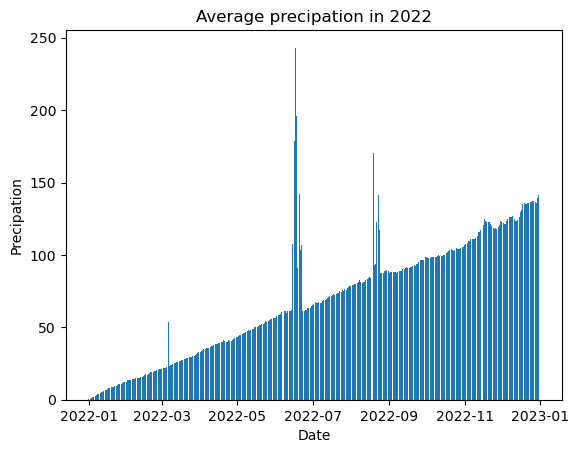

In [46]:
# a. create the figure
fig = plt.figure()

# b. plot
ax = fig.add_subplot(1,1,1)

ax.bar(df3['Date'],df3['Precip'])

ax.set_title('Average precipation in 2022')
ax.set_xlabel('Date')
ax.set_ylabel('Precipation');

**We import data from Yahoo Finance** **DER SKAL RYKKES NOGET OP HER HVOR VI UDVÆLGER CLOSE MV**

In [47]:

OMXC25 = yf.download('^OMXC25', start='2022-01-01', end='2023-01-01', progress=False)
OMXC25.reset_index(inplace=True) 
OMXC25['Date'] =  pd.to_datetime(OMXC25['Date'])
OMXC25


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1971.800049,1982.729980,1962.219971,1970.949951,1970.949951,10582200
1,2022-01-04,1985.459961,1985.900024,1949.790039,1952.810059,1952.810059,17283400
2,2022-01-05,1959.189941,1963.290039,1942.790039,1947.630005,1947.630005,13458600
3,2022-01-07,1886.939941,1891.569946,1865.910034,1867.989990,1867.989990,14073400
4,2022-01-10,1892.000000,1892.630005,1825.430054,1825.510010,1825.510010,14227200
...,...,...,...,...,...,...,...
245,2022-12-23,1686.979980,1701.520020,1685.209961,1695.199951,1695.199951,7560500
246,2022-12-27,1701.160034,1709.910034,1698.150024,1701.630005,1701.630005,5433400
247,2022-12-28,1702.770020,1707.079956,1693.160034,1695.209961,1695.209961,6937600
248,2022-12-29,1691.430054,1712.839966,1688.589966,1712.839966,1712.839966,7364700


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

In [ ]:
fig = plt.figure(figsize=(10,4))

ax_left = fig.add_subplot(1,2,1)
ax_left.set_title('Precipitation')
ax_left.grid(True)
ax_left.bar(precip_stock3['Month'],precip_stock3['Precip'])
ax_left.set_xlabel('Month')
ax_left.set_ylabel('mm')

ax_right = fig.add_subplot(1,2,2)
ax_right.set_title('OMXC25')
ax_right.grid(True)
ax_right.bar(precip_stock3['Month'],precip_stock3['Change_in_stock'])
ax_right.set_xlabel('Month')
ax_right.set_ylabel('Share price')
ax_right.locator_params(axis='both', nbins=4);

**Interactive plot** :

In [ ]:
def interactive_figure(Date, Month, Change_in_stock, Precip):
    filtered_data = precip_stock3[precip_stock3['Month']==Month]

    fig = plt.figure(figsize=(10,4))

    ax_left = fig.add_subplot(1,2,1)
    ax_left.set_title('Precipitation')
    ax_left.grid(True)
    ax_left.bar(filtered_data['Date'],filtered_data['Precip'])
    ax_left.set_xlabel('Date')
    ax_left.set_ylabel('mm')

    ax_right = fig.add_subplot(1,2,2)
    ax_right.set_title('OMXC25')
    ax_right.grid(True)
    ax_right.bar(filtered_data['Date'],filtered_data['Change_in_stock'])
    ax_right.set_xlabel('Date')
    ax_right.set_ylabel('Share price')

    plt.show()

widgets.interact(interactive_figure,
    Date=widgets.fixed(precip_stock3['Date']),
    Month=widgets.Dropdown(description="Month", options=precip_stock3.Month.unique(), value=9),
    Change_in_stock=widgets.fixed(precip_stock3['Change_in_stock']),
    Precip=widgets.fixed(precip_stock3['Precip'])
);

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

We create combinations of our loaded data sets from DMI and Yahoo Finance.

In [ ]:
precip_stock = pd.merge(OMXC25, df3, on='Date', how='left')
precip_stock2 = precip_stock[['Date', 'Close', 'Precip']]
precip_stock2


In [ ]:
# We calculate the pct. change from day-to-day on the closing price of OMXC25
precip_stock2['Change_in_stock'] = ((precip_stock2['Close'] / precip_stock2['Close'].shift(1) - 1)* 100)
precip_stock2

In [ ]:
# Calculate the 10 days with the most progress/decrease in the share price for the OMXC25
# Compare with the amount of rain on these days. Is there a correlation? Viktor

highest = precip_stock2.nlargest(10,'Change_in_stock') 
highest
lowest = precip_stock2.nsmallest(10, 'Change_in_stock')
lowest

Looking at monthly data to get a view of trends

In [ ]:
precip_stock3 = precip_stock2
precip_stock3['Month'] = precip_stock3.Date.dt.month 
precip_stock4 = precip_stock3.groupby('Month').mean()
precip_stock4.reset_index(inplace=True) 
precip_stock3

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.